# Multi-Bot Backtesting Analysis
##
### This script performs backtesting analysis on four trading bots:
### 1. TSLA Long Momentum Bot
### 2. TSLA Short Momentum Bot
### 3. COIN Long Momentum Bot
### 4. COIN Short Momentum Bot
###
### The analysis uses historical tick data from our PostgreSQL database to evaluate
### strategy performance and generate insights for optimization.

In [42]:
import asyncio
import asyncpg
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
from decimal import Decimal
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Configure plotting style for consistency
plt.style.use('ggplot')
sns.set_palette("husl")

# Database connection setup
async def create_db_pool():
    """Create and return a connection pool to the PostgreSQL database."""
    return await asyncpg.create_pool(
        user='clayb',
        password='musicman',
        database='tick_data',
        host='localhost'
    )
# Create database pool
db_pool = await create_db_pool()

async def load_tick_data(symbol):
    """
    Load tick data for a given symbol from the database.
    
    Args:
        symbol (str): The stock symbol to load data for
        
    Returns:
        pandas.DataFrame: DataFrame containing timestamp, price, and volume data
    """
    async with db_pool.acquire() as conn:
        # Get data range information
        range_info = await conn.fetchrow("""
            SELECT 
                MIN(timestamp) as start_date,
                MAX(timestamp) as end_date,
                COUNT(*) as tick_count
            FROM tick_data
            WHERE ticker = $1
        """, symbol)
        
        print(f"\nData range for {symbol}:")
        print(f"Start date: {range_info['start_date']}")
        print(f"End date: {range_info['end_date']}")
        print(f"Total ticks: {range_info['tick_count']}")
        
        # Load the actual tick data
        rows = await conn.fetch("""
            SELECT timestamp, price, volume
            FROM tick_data
            WHERE ticker = $1
            ORDER BY timestamp ASC
        """, symbol)
        
        return pd.DataFrame(rows, columns=['timestamp', 'price', 'volume'])


In [52]:
# Load data for both symbols
tsla_data = await load_tick_data('TSLA')
coin_data = await load_tick_data('COIN')


Data range for TSLA:
Start date: 2025-01-23 03:03:34.515986+00:00
End date: 2025-01-25 03:33:30.508918+00:00
Total ticks: 15968

Data range for COIN:
Start date: 2025-01-22 01:31:50.128491+00:00
End date: 2025-01-25 03:33:18.991152+00:00
Total ticks: 27497


In [49]:
class BaseBot:
    """
    Base trading bot class implementing core functionality for both long and short strategies.
    Uses a price buffer system to track recent price movements and make trading decisions.
    """
    
    def __init__(self, symbol, direction):
        self.symbol = symbol
        self.direction = direction
        self.position = None
        self.entry_price = None
        self.trailing_stop = Decimal('0.002')  # 0.2%
        self.position_size = 10000  # Standard position size of $10,000
        self.trades = []
        
        # Initialize price buffer system
        self.price_buffer_size = 2  # We'll compare two consecutive prices
        self.recent_prices = []  # Buffer to store recent price data
        self.reset_price_trackers()
    
    def reset_price_trackers(self):
        """Reset price tracking variables based on strategy direction."""
        if self.direction == 'LONG':
            self.price_extreme = Decimal('0')
        else:  # SHORT
            self.price_extreme = Decimal('inf')
    
    def check_trailing_stop(self, current_price):
        """
        Check if the trailing stop has been hit and update the trailing stop level.
        For long positions, stop rises with price. For shorts, stop falls with price.
        """
        if self.position is None:
            return False
            
        if self.direction == 'LONG':
            if current_price > self.price_extreme:
                self.price_extreme = current_price
            stop_price = self.price_extreme * (1 - self.trailing_stop)
            return current_price <= stop_price
        else:  # SHORT
            if current_price < self.price_extreme:
                self.price_extreme = current_price
            stop_price = self.price_extreme * (1 + self.trailing_stop)
            return current_price >= stop_price
    
    async def process_tick(self, ticker, price, timestamp):
        """
        Process each new tick of market data and execute trades if conditions are met.
        Uses a price buffer to track recent price movements for decision making.
        """
        # Skip if not our target symbol
        if ticker != self.symbol:
            return

        try:
            # Ensure price is a Decimal for consistent calculations
            if not isinstance(price, Decimal):
                price = Decimal(str(price))
            
            # Add new price to our buffer with its timestamp
            self.recent_prices.append({'price': price, 'timestamp': timestamp})

            # Keep buffer at desired size
            if len(self.recent_prices) > self.price_buffer_size:
                self.recent_prices.pop(0)  # Remove oldest price

            # Wait until we have enough prices to compare
            if len(self.recent_prices) == self.price_buffer_size:
                # Get first and last price from our buffer
                first_tick = self.recent_prices[0]
                last_tick = self.recent_prices[-1]

                # Check for trade conditions based on strategy direction
                if self.position is None:  # Looking for entry
                    if self.direction == 'LONG':
                        if first_tick['price'] < last_tick['price']:  # Price rising
                            quantity = int(self.position_size / price)
                            await self.execute_trade('ENTRY', timestamp, price, quantity)
                    else:  # SHORT
                        if first_tick['price'] > last_tick['price']:  # Price falling
                            quantity = int(self.position_size / price)
                            await self.execute_trade('ENTRY', timestamp, price, quantity)
                
                # Check trailing stop if in position
                elif self.check_trailing_stop(price):
                    await self.execute_trade('EXIT', timestamp, price, self.quantity)

        except Exception as e:
            print(f"Error processing tick: {e}")

    async def execute_trade(self, action, timestamp, price, quantity=None):
        """
        Execute a trade and record the details for later analysis.
        Handles both entry and exit trades with proper position tracking.

        Args:
            action (str): 'ENTRY' or 'EXIT' to indicate trade direction
            timestamp (datetime): When the trade occurs
            price (Decimal): The execution price
            quantity (int, optional): Number of shares to trade
        """
        if action == 'ENTRY':
            self.position = 1
            self.entry_price = price
            self.price_extreme = price
            self.entry_time = timestamp
            self.quantity = quantity
        else:  # EXIT
            # Calculate P&L based on direction
            pnl = (price - self.entry_price) if self.direction == 'LONG' else (self.entry_price - price)
            pnl = pnl * self.quantity  # Multiply by position size
            
            # Record trade details
            self.trades.append({
                'entry_time': self.entry_time,
                'exit_time': timestamp,
                'entry_price': float(self.entry_price),
                'exit_price': float(price),
                'quantity': self.quantity,
                'pnl': float(pnl),
                'duration': timestamp - self.entry_time
            })
            
            # Reset position tracking
            self.position = None
            self.entry_price = None
            self.quantity = None
            self.reset_price_trackers()
    
    async def execute_trade(self, action, timestamp, price, quantity=None):
        """
        Execute a trade and record the details for later analysis.
        Handles both entry and exit trades with proper position tracking.

        Args:
            action (str): 'ENTRY' or 'EXIT' to indicate trade direction
            timestamp (datetime): When the trade occurs
            price (Decimal): The execution price
            quantity (int, optional): Number of shares to trade
        """
        if action == 'ENTRY':
            self.position = 1
            self.entry_price = price
            self.price_extreme = price
            self.entry_time = timestamp
            self.quantity = quantity
        else:  # EXIT
            try:
                # Calculate P&L based on direction
                pnl = (price - self.entry_price) if self.direction == 'LONG' else (self.entry_price - price)
                pnl = pnl * self.quantity  # Multiply by position size
                
                # Record trade details
                self.trades.append({
                    'entry_time': self.entry_time,
                    'exit_time': timestamp,
                    'entry_price': float(self.entry_price),
                    'exit_price': float(price),
                    'quantity': self.quantity,
                    'pnl': float(pnl),
                    'duration': timestamp - self.entry_time
                })
                
                # Reset position tracking
                self.position = None
                self.entry_price = None
                self.quantity = None
                self.reset_price_trackers()
                
            except Exception as e:
                print(f"Error executing {action} trade: {e}, Price: {price}, Entry Price: {self.entry_price}, Quantity: {self.quantity}")

In [54]:
def run_backtest(symbol_data, symbol, window_size=60):
    """
    Run backtesting simulation for both long and short strategies on a symbol.
    
    Args:
        symbol_data (pd.DataFrame): Historical tick data for the symbol
        symbol (str): Stock symbol being tested
        window_size (int): Size of the rolling window for price analysis
        
    Returns:
        tuple: Lists of trades for long and short strategies
    """
    # Create both long and short bots for the symbol
    long_bot = BaseBot(symbol, 'LONG')
    short_bot = BaseBot(symbol, 'SHORT')
    
    # Create rolling window for price history
    price_history = []
    
    # Process each tick
    for idx, row in symbol_data.iterrows():
        price_history.append(row['price'])
        if len(price_history) > window_size:
            price_history.pop(0)
            
        price_series = pd.Series(price_history)
        
        # Process tick for both bots
        long_bot.process_tick(row['timestamp'], row['price'], price_series)
        short_bot.process_tick(row['timestamp'], row['price'], price_series)
    
    return long_bot.trades, short_bot.trades

# Run backtests for both symbols
tsla_long_trades, tsla_short_trades = run_backtest(tsla_data, 'TSLA')
coin_long_trades, coin_short_trades = run_backtest(coin_data, 'COIN')

def analyze_performance(trades, bot_name):
    """
    Analyze trading performance and calculate key metrics.
    
    Args:
        trades (list): List of trade dictionaries containing entry/exit details
        bot_name (str): Name of the strategy being analyzed
        
    Returns:
        pd.DataFrame: DataFrame of trade details with performance metrics
    """
    if not trades:
        print(f"No trades for {bot_name}")
        return None
        
    trades_df = pd.DataFrame(trades)
    
    # Calculate basic metrics
    total_trades = len(trades)
    winning_trades = len(trades_df[trades_df['pnl'] > 0])
    total_pnl = trades_df['pnl'].sum()
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if winning_trades > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if len(trades_df[trades_df['pnl'] < 0]) > 0 else 0
    
    # Calculate advanced metrics
    if len(trades_df) > 0:
        # Sharpe Ratio calculation
        daily_returns = trades_df.set_index('exit_time')['pnl'].resample('D').sum()
        sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std()) if daily_returns.std() != 0 else 0
        
        # Maximum Drawdown calculation
        cumulative_pnl = trades_df['pnl'].cumsum()
        running_max = cumulative_pnl.expanding(min_periods=1).max()
        drawdowns = (cumulative_pnl - running_max) / running_max * 100
        max_drawdown = drawdowns.min()
        
        # Profit Factor calculation
        gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
        gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else float('inf')
        
        # Win streak analysis
        trades_df['win'] = trades_df['pnl'] > 0
        trades_df['streak'] = (trades_df['win'] != trades_df['win'].shift(1)).cumsum()
        win_streaks = trades_df[trades_df['win']].groupby('streak').size()
        
        # Print performance summary
        print(f"\n=== {bot_name} Performance ===")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Total P&L: ${total_pnl:.2f}")
        print(f"Average Win: ${avg_win:.2f}")
        print(f"Average Loss: ${avg_loss:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Maximum Drawdown: {max_drawdown:.2f}%")
        print(f"Profit Factor: {profit_factor:.2f}")
        if len(win_streaks) > 0:
            print(f"Longest Win Streak: {win_streaks.max()}")
            print(f"Average Win Streak: {win_streaks.mean():.2f}")
    
    return trades_df

# Analyze performance for each strategy
tsla_long_df = analyze_performance(tsla_long_trades, "TSLA Long")
tsla_short_df = analyze_performance(tsla_short_trades, "TSLA Short")
coin_long_df = analyze_performance(coin_long_trades, "COIN Long")
coin_short_df = analyze_performance(coin_short_trades, "COIN Short")

C:\Users\clayb\AppData\Local\Temp\ipykernel_23712\3829972655.py:29: RuntimeWarning: coroutine 'BaseBot.process_tick' was never awaited
  long_bot.process_tick(row['timestamp'], row['price'], price_series)
C:\Users\clayb\AppData\Local\Temp\ipykernel_23712\3829972655.py:30: RuntimeWarning: coroutine 'BaseBot.process_tick' was never awaited
  short_bot.process_tick(row['timestamp'], row['price'], price_series)
C:\Users\clayb\AppData\Local\Temp\ipykernel_23712\3829972655.py:29: RuntimeWarning: coroutine 'BaseBot.process_tick' was never awaited
  long_bot.process_tick(row['timestamp'], row['price'], price_series)
C:\Users\clayb\AppData\Local\Temp\ipykernel_23712\3829972655.py:30: RuntimeWarning: coroutine 'BaseBot.process_tick' was never awaited
  short_bot.process_tick(row['timestamp'], row['price'], price_series)


No trades for TSLA Long
No trades for TSLA Short
No trades for COIN Long
No trades for COIN Short


In [55]:
def analyze_performance(trades, bot_name):
    """
    Analyze trading performance and calculate key metrics.
    
    Args:
        trades (list): List of trade dictionaries containing entry/exit details
        bot_name (str): Name of the strategy being analyzed
        
    Returns:
        pd.DataFrame: DataFrame of trade details with performance metrics
    """
    if not trades:
        print(f"No trades for {bot_name}")
        return None
        
    trades_df = pd.DataFrame(trades)
    
    # Calculate basic metrics
    total_trades = len(trades)
    winning_trades = len(trades_df[trades_df['pnl'] > 0])
    total_pnl = trades_df['pnl'].sum()
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if winning_trades > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if len(trades_df[trades_df['pnl'] < 0]) > 0 else 0
    
    # Calculate advanced metrics
    if len(trades_df) > 0:
        # Sharpe Ratio calculation
        daily_returns = trades_df.set_index('exit_time')['pnl'].resample('D').sum()
        sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std()) if daily_returns.std() != 0 else 0
        
        # Maximum Drawdown calculation
        cumulative_pnl = trades_df['pnl'].cumsum()
        running_max = cumulative_pnl.expanding(min_periods=1).max()
        drawdowns = (cumulative_pnl - running_max) / running_max * 100
        max_drawdown = drawdowns.min()
        
        # Profit Factor calculation
        gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
        gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else float('inf')
        
        # Win streak analysis
        trades_df['win'] = trades_df['pnl'] > 0
        trades_df['streak'] = (trades_df['win'] != trades_df['win'].shift(1)).cumsum()
        win_streaks = trades_df[trades_df['win']].groupby('streak').size()
        
        # Print performance summary
        print(f"\n=== {bot_name} Performance ===")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Total P&L: ${total_pnl:.2f}")
        print(f"Average Win: ${avg_win:.2f}")
        print(f"Average Loss: ${avg_loss:.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Maximum Drawdown: {max_drawdown:.2f}%")
        print(f"Profit Factor: {profit_factor:.2f}")
        if len(win_streaks) > 0:
            print(f"Longest Win Streak: {win_streaks.max()}")
            print(f"Average Win Streak: {win_streaks.mean():.2f}")
    
    return trades_df

# Analyze performance for each strategy
tsla_long_df = analyze_performance(tsla_long_trades, "TSLA Long")
tsla_short_df = analyze_performance(tsla_short_trades, "TSLA Short")
coin_long_df = analyze_performance(coin_long_trades, "COIN Long")
coin_short_df = analyze_performance(coin_short_trades, "COIN Short")

No trades for TSLA Long
No trades for TSLA Short
No trades for COIN Long
No trades for COIN Short


In [56]:
# Analyze performance for each strategy
tsla_long_df = analyze_performance(tsla_long_trades, "TSLA Long")
tsla_short_df = analyze_performance(tsla_short_trades, "TSLA Short")
coin_long_df = analyze_performance(coin_long_trades, "COIN Long")
coin_short_df = analyze_performance(coin_short_trades, "COIN Short")

No trades for TSLA Long
No trades for TSLA Short
No trades for COIN Long
No trades for COIN Short


C:\Users\clayb\AppData\Local\Temp\ipykernel_23712\3106711772.py:370: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


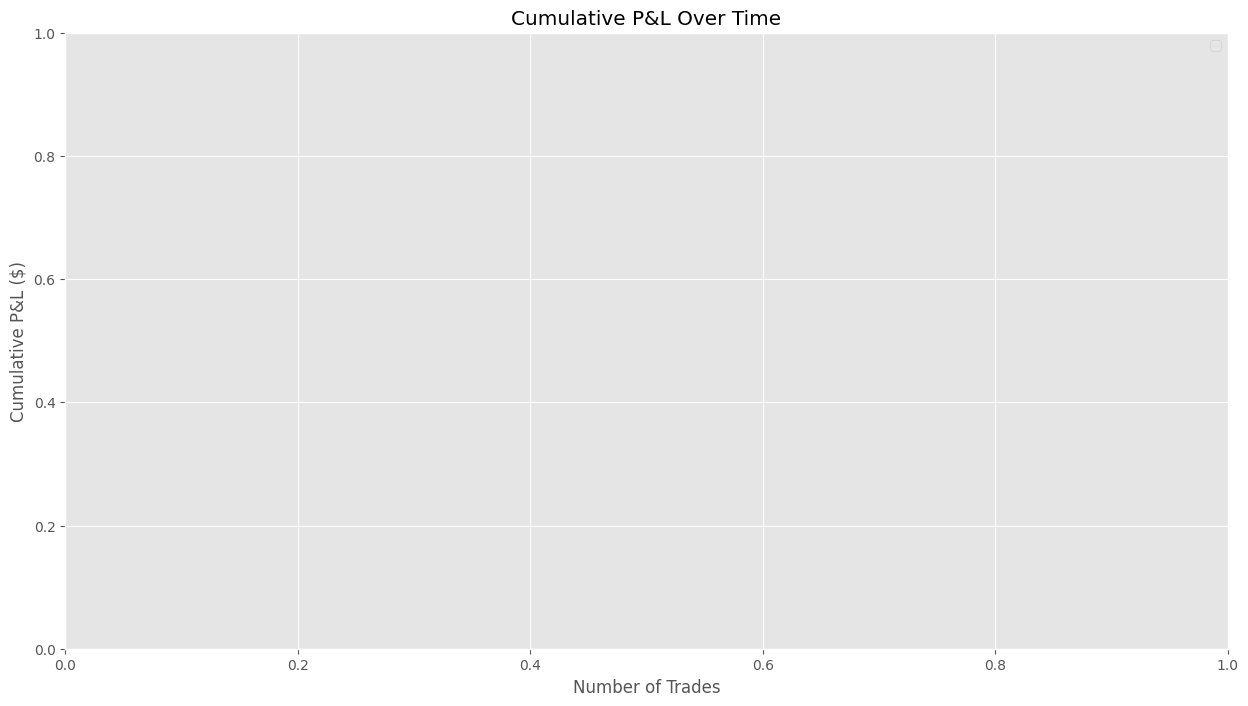

C:\Users\clayb\AppData\Local\Temp\ipykernel_23712\3106711772.py:387: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(duration_data, labels=names)


ValueError: Dimensions of labels and X must be compatible

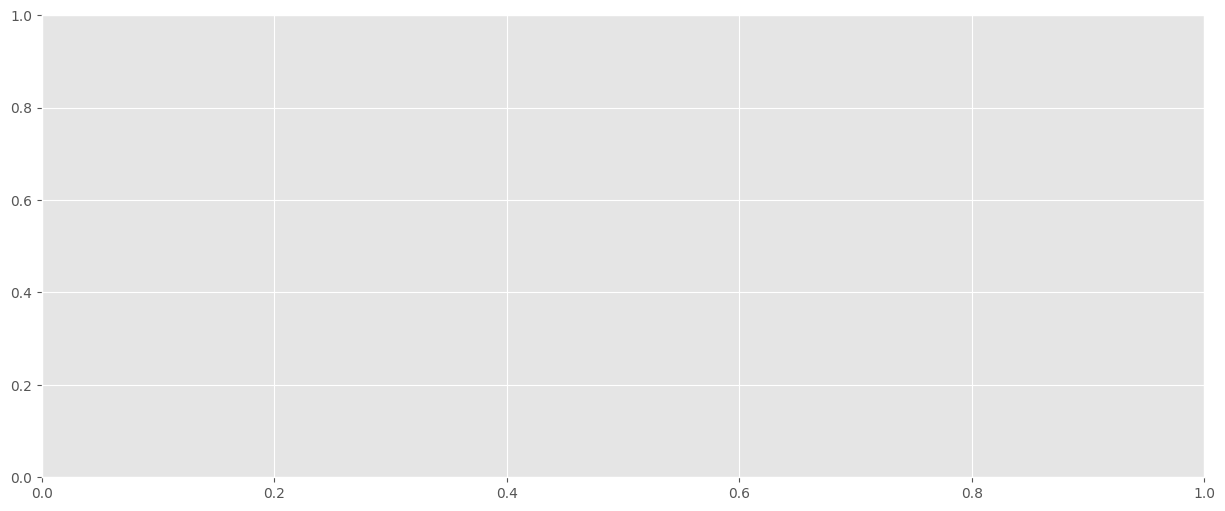

In [57]:
def plot_pnl_distribution(dfs, names):
    """Create violin plots showing P&L distribution for each strategy."""
    plt.figure(figsize=(15, 8))
    
    data = []
    labels = []
    
    for df, name in zip(dfs, names):
        if df is not None and not df.empty:
            data.append(df['pnl'])
            labels.extend([name] * len(df))
    
    sns.violinplot(data=data)
    plt.xticks(range(len(names)), names, rotation=45)
    plt.title('P&L Distribution by Strategy')
    plt.ylabel('P&L ($)')
    plt.grid(True)
    plt.show()

# Generate visualizations
plot_cumulative_pnl(
    [tsla_long_df, tsla_short_df, coin_long_df, coin_short_df],
    ['TSLA Long', 'TSLA Short', 'COIN Long', 'COIN Short']
)

plot_trade_durations(
    [tsla_long_df, tsla_short_df, coin_long_df, coin_short_df],
    ['TSLA Long', 'TSLA Short', 'COIN Long', 'COIN Short']
)

plot_pnl_distribution(
    [tsla_long_df, tsla_short_df, coin_long_df, coin_short_df],
    ['TSLA Long', 'TSLA Short', 'COIN Long', 'COIN Short']
)

# Clean up database connection
await db_pool.close()

## Strategy evaluation notes:
## 1. Risk-Adjusted Returns
##    - Compare Sharpe ratios across strategies
##    - Analyze maximum drawdowns for risk assessment
##
## 2. Trade Characteristics
##    - Evaluate win rates and profit factors
##    - Study trade duration patterns
##    - Analyze win streak distributions
##
## 3. Strategy-Specific Insights
##    - Identify market conditions favoring each strategy
##    - Compare long vs short performance
##    - Note potential areas for optimization
##
## 4. Optimization Opportunities
##    - Consider adjusting trailing stop percentages
##    - Investigate optimal trade duration patterns
##    - Look for opportunities to combine complementary strategies

# **Attempt: GOT IT!**
# Imports and Configuration

In [1]:
# !pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, time, timedelta  # Added timedelta here
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

# Strategy Configuration
SYMBOL = 'TSLA'
TOTAL_USD_AMOUNT = 25000
TRAILING_STOP_PERCENT = 0.002  # 0.2%


# Trading window (Eastern Time)
MARKET_START = time(hour=9, minute=31)
MARKET_STOP = time(hour=15, minute=45)
eastern_tz = pytz.timezone('US/Eastern')

def in_trading_window(timestamp):
    """Checks if timestamp is Eastern Time and within trading window"""
    if timestamp.tz != eastern_tz:
        timestamp = timestamp.tz_convert(eastern_tz)
    t = timestamp.time()
    return MARKET_START <= t <= MARKET_STOP

# Fetching Market Data

In [11]:
# Second cell - Download recent data
def get_recent_market_data(symbol, days=7):
    """
    Fetch the most recent available market data for a given symbol over a specified number of days.

    Parameters:
    symbol (str): The ticker symbol of the financial instrument to download data for.
    days (int): The number of past days to retrieve data for. Defaults to 7 days.

    Returns:
    pd.DataFrame: A DataFrame containing the market data with a datetime index in Eastern Time.
                  Returns None if data download fails or no data is received.

    The function uses the yfinance library to download minute-level data for the specified symbol.
    It ensures the data's datetime index is localized to Eastern Time, which is crucial for aligning
    with the US market hours.
    """
    # Define the end time as the current time
    end = datetime.now()
    # Calculate the start time by subtracting the specified number of days from the end time
    start = end - pd.Timedelta(days=days)
    
    try:
        # Attempt to download the data using yfinance's download function
        df = yf.download(symbol, 
                        start=start,
                        end=end,
                        interval='1m',  # Set the data interval to 1 minute
                        prepost=False)  # Exclude pre-market and post-market data
        
        # Check if the DataFrame is empty, indicating no data was received
        if df.empty:
            raise ValueError(f"No data received for {symbol}")
            
        # Convert the DataFrame's index to a timezone-aware datetime index in Eastern Time
        df.index = pd.DatetimeIndex(df.index)
        if df.index.tz is None:
            # Localize the index to Eastern Time if it is not already timezone-aware
            df.index = df.index.tz_localize('America/New_York')
        else:
            # Convert the index to Eastern Time if it has a different timezone
            df.index = df.index.tz_convert('America/New_York')
            
        return df  # Return the DataFrame with the market data
        
    except Exception as e:
        # Print an error message if an exception occurs during data download
        print(f"Error downloading data: {str(e)}")
        return None  # Return None to indicate failure

# Try to get data
print("Downloading recent market data...")
data = get_recent_market_data(SYMBOL)

if data is not None:
    # If data is successfully downloaded, print the number of minutes of data received
    print(f"\nSuccessfully downloaded {len(data)} minutes of data")
    print("\nSample of the data:")
    display(data.head())  # Display the first few rows of the data
    print("\nTime range:")
    # Print the start and end of the data's datetime index
    print(f"Start: {data.index.min()}")
    print(f"End: {data.index.max()}")
else:
    # Print a failure message if data download was unsuccessful
    print("Failed to download data")

[*********************100%***********************]  1 of 1 completed


Successfully downloaded 1377 minutes of data

Sample of the data:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Datetime,,,,,,
2024-12-24 12:20:00-05:00,452.480011,452.480011,452.910004,452.422485,452.910004,0
2024-12-24 12:21:00-05:00,452.660095,452.660095,452.809998,452.467499,452.524994,57510
2024-12-24 12:22:00-05:00,452.700012,452.700012,453.000000,452.540009,452.605011,163556
2024-12-24 12:23:00-05:00,452.973602,452.973602,453.079987,452.631195,452.631195,119326
2024-12-24 12:24:00-05:00,452.839996,452.839996,452.989990,452.700012,452.984985,77207



Time range:
Start: 2024-12-24 12:20:00-05:00
End: 2024-12-31 12:18:00-05:00


In [12]:
# Second cell - Download most recent available data
def get_recent_market_data(symbol, days=5):
    """Get the most recent available market data"""
    end = datetime.now()
    start = end - timedelta(days=days)
    
    try:
        # Download data
        df = yf.download(symbol, 
                        start=start,
                        end=end,
                        interval='1m',
                        prepost=False)
        
        if df.empty:
            raise ValueError(f"No data received for {symbol}")
            
        # Convert index to Eastern Time
        df.index = pd.DatetimeIndex(df.index)
        if df.index.tz is None:
            df.index = df.index.tz_localize('America/New_York')
        else:
            df.index = df.index.tz_convert('America/New_York')
            
        return df
        
    except Exception as e:
        print(f"Error downloading data: {str(e)}")
        return None

# Try to get data
data = get_recent_market_data(SYMBOL)

if data is not None:
    print(f"Successfully downloaded {len(data)} minutes of data")
    print("\nSample of the data:")
    display(data.head())
    print("\nTime range:")
    print(f"Start: {data.index.min()}")
    print(f"End: {data.index.max()}")
else:
    print("Failed to download data")

[*********************100%***********************]  1 of 1 completed

Successfully downloaded 1168 minutes of data

Sample of the data:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Datetime,,,,,,
2024-12-26 12:20:00-05:00,455.809998,455.809998,456.450012,455.649994,456.149994,0
2024-12-26 12:21:00-05:00,455.885010,455.885010,456.259888,455.800110,455.865997,57150
2024-12-26 12:22:00-05:00,456.089996,456.089996,456.230011,455.740112,455.899994,69434
2024-12-26 12:23:00-05:00,455.820892,455.820892,456.399902,455.820007,456.114990,57317
2024-12-26 12:24:00-05:00,456.010010,456.010010,456.369904,455.820099,455.884003,50358



Time range:
Start: 2024-12-26 12:20:00-05:00
End: 2024-12-31 12:18:00-05:00


In [4]:
# Second cell - Download recent data
def get_recent_market_data(symbol, days=5):
    """
    Fetch the most recent available market data for a given symbol over a specified number of days.
    Downloads data in chunks to handle Yahoo Finance's 8-day limit for 1-minute data.

    Parameters:
    symbol (str): The ticker symbol of the financial instrument to download data for.
    days (int): The number of past days to retrieve data for. Defaults to 5 days.

    Returns:
    pd.DataFrame: A DataFrame containing the market data with a datetime index in Eastern Time.
                 Returns None if data download fails or no data is received.
    """
    end = datetime.now()
    start = end - timedelta(days=days)
    
    all_data = []
    current_start = start
    
    while current_start < end:
        # Calculate chunk end date (7 days from start or end date, whichever is sooner)
        chunk_end = min(current_start + timedelta(days=7), end)
        
        try:
            # Download data for this chunk
            df = yf.download(symbol, 
                           start=current_start,
                           end=chunk_end,
                           interval='1m',
                           prepost=False)
            
            if not df.empty:
                # Convert index to Eastern Time
                df.index = pd.DatetimeIndex(df.index)
                if df.index.tz is None:
                    df.index = df.index.tz_localize('America/New_York')
                else:
                    df.index = df.index.tz_convert('America/New_York')
                    
                all_data.append(df)
                print(f"Successfully downloaded chunk from {current_start.date()} to {chunk_end.date()}")
            
        except Exception as e:
            print(f"Error downloading chunk {current_start.date()} to {chunk_end.date()}: {str(e)}")
            
        # Move to next chunk
        current_start = chunk_end
    
    if not all_data:
        print("No data was downloaded")
        return None
        
    # Combine all chunks
    final_data = pd.concat(all_data)
    # Remove any duplicate indices that might occur at chunk boundaries
    final_data = final_data[~final_data.index.duplicated(keep='first')]
    # Sort by index just in case
    final_data.sort_index(inplace=True)
            
    return final_data

# Try to get data
print("Downloading recent market data...")
data = get_recent_market_data(SYMBOL)

if data is not None:
    # If data is successfully downloaded, print the number of minutes of data received
    print(f"\nSuccessfully downloaded {len(data)} minutes of data")
    print("\nSample of the data:")
    display(data.head())  # Display the first few rows of the data
    print("\nTime range:")
    # Print the start and end of the data's datetime index
    print(f"Start: {data.index.min()}")
    print(f"End: {data.index.max()}")
else:
    # Print a failure message if data download was unsuccessful
    print("Failed to download data")

[*********************100%***********************]  1 of 1 completed

Successfully downloaded chunk from 2024-12-26 to 2024-12-31

Successfully downloaded 1169 minutes of data

Sample of the data:


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Datetime,,,,,,
2024-12-26 10:38:00-05:00,461.718506,461.718506,462.570007,461.000000,462.304993,0
2024-12-26 10:39:00-05:00,461.184998,461.184998,461.979889,460.609985,461.184998,144553
2024-12-26 10:40:00-05:00,460.612000,460.612000,461.379913,460.492401,461.209991,112362
2024-12-26 10:41:00-05:00,459.834991,459.834991,460.910004,459.630096,460.640015,325808
2024-12-26 10:42:00-05:00,460.130005,460.130005,460.459991,459.440002,459.838287,186032



Time range:
Start: 2024-12-26 10:38:00-05:00
End: 2024-12-31 10:36:00-05:00


In [5]:
def get_recent_market_data(symbol, total_days=30):
    """
    Get market data in chunks to handle yfinance's 8-day limit for 1-minute data
    """
    end_date = datetime.now()
    all_data = []
    chunk_size = 7  # Use 7 days to be safe (less than the 8-day limit)
    
    for i in range(0, total_days, chunk_size):
        chunk_end = end_date - timedelta(days=i)
        chunk_start = chunk_end - timedelta(days=chunk_size)
        
        print(f"Downloading chunk from {chunk_start.date()} to {chunk_end.date()}")
        
        try:
            chunk_data = yf.download(
                symbol,
                start=chunk_start,
                end=chunk_end,
                interval='1m',
                prepost=False
            )
            
            if not chunk_data.empty:
                all_data.append(chunk_data)
                
        except Exception as e:
            print(f"Error downloading chunk: {str(e)}")
            continue
    
    if not all_data:
        print("No data was downloaded")
        return None
        
    # Combine all chunks and sort by index
    combined_data = pd.concat(all_data).sort_index()
    
    # Remove duplicates that might occur at chunk boundaries
    combined_data = combined_data[~combined_data.index.duplicated(keep='first')]
    
    # Convert index to Eastern Time
    if combined_data.index.tz is None:
        combined_data.index = combined_data.index.tz_localize('America/New_York')
    else:
        combined_data.index = combined_data.index.tz_convert('America/New_York')
    
    print(f"Successfully downloaded {len(combined_data)} minutes of data")
    return combined_data

# Download data
print("Downloading market data in chunks...")
data = get_recent_market_data('SPY', total_days=30)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1m 2024-11-26 10:37:28.345951 -> 2024-12-03 10:37:28.345951) (Yahoo error = "1m data not available for startTime=1732635448 and endTime=1733240248. The requested range must be within the last 30 days.")')


Successfully downloaded 7208 minutes of data


# Algo 1

  **Strategy:**
- Between 9:31 AM and 3:45 PM Eastern Time:
  If the last minute close of COIN < last minute open AND the current price of COIN is below the current minute's open:
    -> Sell $10,000 USD worth of COIN (Short position)
  Exit Condition:
    -> A trailing stop of 0.2% from the entry price to close the position.

**Important Considerations:**
- This code snippet uses ib_insync for IB API connectivity.
- Ensure that you have TWS or IB Gateway running with the API enabled.
- Make sure to configure your account credentials and have proper market data subscriptions.
- Time checks use Eastern Time. Adjust if your environment runs in a different timezone.
- Trailing stops are implemented here by monitoring the price. Another approach is to use IB’s native trailing stop order type if desired.

In [6]:
# Fourth cell - Run backtest if we have data
def backtest_strategy(data):
    """Backtest the short strategy"""
    position_open = False
    entry_price = None
    position_qty = 0
    cash = 25000  # Initial capital
    trades = []
    equity_curve = []
    
    # Create shifted columns for previous bar comparison
    data = data.copy()  # Create a copy to avoid modifying original data
    data['prev_open'] = data['Open'].shift(1)
    data['prev_close'] = data['Close'].shift(1)
    
    # Skip first row since it will have NaN values for prev_open and prev_close
    for timestamp, row in data.iloc[1:].iterrows():
        current_price = float(row['Close'])  # Convert to float
        
        if in_trading_window(timestamp):
            # Entry logic
            if not position_open:
                # Check if last minute close < last minute open AND current price < current minute open
                prev_close = float(row['prev_close'])
                prev_open = float(row['prev_open'])
                current_open = float(row['Open'])
                
                if (prev_close < prev_open) and (current_price < current_open):
                    shares = int(TOTAL_USD_AMOUNT / current_price)
                    if shares > 0:
                        position_open = True
                        entry_price = current_price
                        position_qty = shares
                        trades.append({
                            'entry_time': timestamp,
                            'entry_price': entry_price,
                            'qty': position_qty,
                            'direction': 'short'
                        })
            
            # Exit logic - trailing stop
            elif position_open:
                stop_price = float(entry_price * (1 + TRAILING_STOP_PERCENT))
                if float(current_price) >= stop_price:  # Convert to float for comparison
                    # Close position
                    pnl = (entry_price - current_price) * position_qty
                    cash += pnl
                    trades[-1].update({
                        'exit_time': timestamp,
                        'exit_price': current_price,
                        'pnl': pnl
                    })
                    
                    position_open = False
                    position_qty = 0
                    entry_price = None
        
        # Close position at end of trading window if still open
        elif position_open:
            pnl = (entry_price - current_price) * position_qty
            cash += pnl
            trades[-1].update({
                'exit_time': timestamp,
                'exit_price': current_price,
                'pnl': pnl
            })

            position_open = False
            position_qty = 0
            entry_price = None

        # Track equity
        current_equity = cash
        if position_open:
            current_equity += (entry_price - current_price) * position_qty
        equity_curve.append((timestamp, current_equity))
    
    trades_df = pd.DataFrame(trades)
    equity_df = pd.DataFrame(equity_curve, columns=['timestamp', 'equity']).set_index('timestamp')
    
    # Add additional metrics if trades were made
    if not trades_df.empty:
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        trades_df['return'] = trades_df['pnl'] / TOTAL_USD_AMOUNT
    
    return trades_df, equity_df

C:\Users\clayb\AppData\Local\Temp\ipykernel_15856\3374611899.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(row['Close'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_15856\3374611899.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_close = float(row['prev_close'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_15856\3374611899.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_open = float(row['prev_open'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_15856\3374611899.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_open = float(row['Open'])


=== Backtest Results ===
Number of trades: 17
Total P&L: $-202.64
Average P&L per trade: $-12.67
Win rate: 11.8%


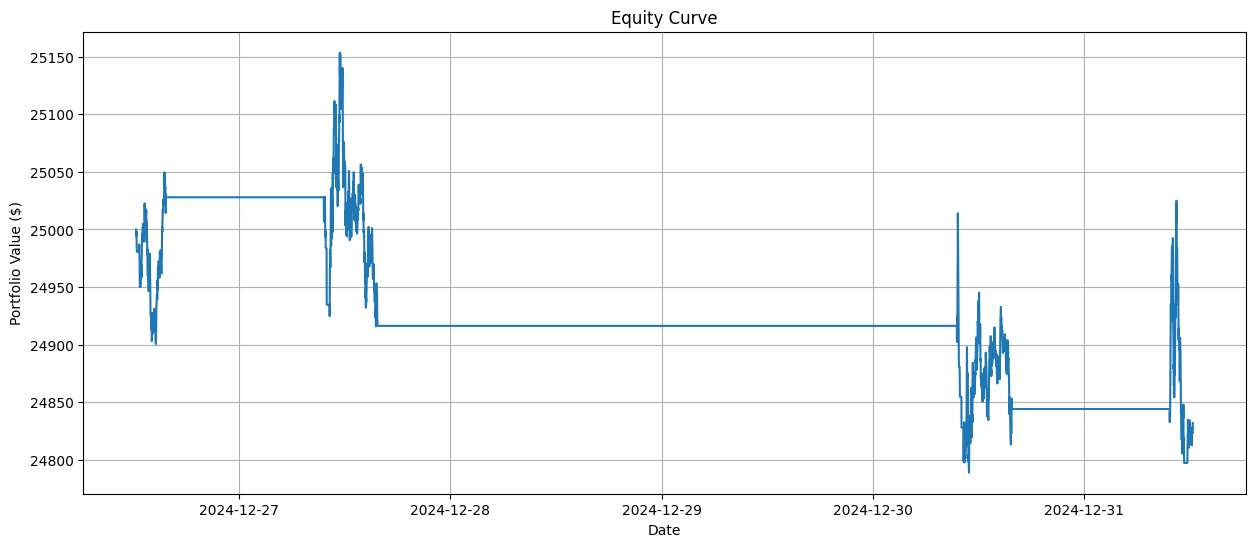


=== Trade Details ===


,entry_time,entry_price,exit_time,exit_price,qty,pnl,duration,return
0,2024-12-26 12:22:00-05:00,456.089996,2024-12-26 12:28:00-05:00,455.165314,21,-19.418335,0 days 00:06:00,-0.001942
1,2024-12-26 12:42:00-05:00,453.570801,2024-12-26 12:47:00-05:00,452.187805,22,-30.425903,0 days 00:05:00,-0.003043
2,2024-12-26 12:53:00-05:00,452.849915,2024-12-26 14:00:00-05:00,451.763794,22,-23.894653,0 days 01:07:00,-0.002389
3,2024-12-26 14:02:00-05:00,452.207794,2024-12-26 14:08:00-05:00,451.160004,22,-23.051392,0 days 00:06:00,-0.002305
4,2024-12-26 14:10:00-05:00,452.202301,2024-12-26 15:46:00-05:00,457.869995,22,124.689270,0 days 01:36:00,0.012469
5,2024-12-27 09:40:00-05:00,444.260010,2024-12-27 09:41:00-05:00,443.299988,22,-21.120483,0 days 00:01:00,-0.002112
6,2024-12-27 09:46:00-05:00,442.600006,2024-12-27 09:53:00-05:00,441.554993,22,-22.990295,0 days 00:07:00,-0.002299
7,2024-12-27 09:58:00-05:00,439.734985,2024-12-27 10:00:00-05:00,437.500000,22,-49.169678,0 days 00:02:00,-0.004917
8,2024-12-27 10:19:00-05:00,429.609985,2024-12-27 15:46:00-05:00,428.813293,23,-18.323914,0 days 05:27:00,-0.001832
9,2024-12-30 09:31:00-05:00,422.640106,2024-12-30 09:45:00-05:00,421.106812,23,-35.265778,0 days 00:14:00,-0.003527



=== Additional Statistics ===
Sharpe Ratio (assuming 0% risk-free rate): -4.85
Max Drawdown: $364.49
Average Trade Duration: 0 days 00:59:41.250000


In [13]:
# Run backtest and analyze results
if data is not None:
    trades_df, equity_df = backtest_strategy(data)
    
    print("=== Backtest Results ===")
    print(f"Number of trades: {len(trades_df)}")
    
    if not trades_df.empty:
        print(f"Total P&L: ${trades_df['pnl'].sum():.2f}")
        print(f"Average P&L per trade: ${trades_df['pnl'].mean():.2f}")
        print(f"Win rate: {(trades_df['pnl'] > 0).mean():.1%}")
        
        # Plot equity curve
        plt.figure(figsize=(15, 6))
        plt.plot(equity_df.index, equity_df['equity'])
        plt.title('Equity Curve')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.show()
        
        print("\n=== Trade Details ===")
        display(trades_df[['entry_time', 'entry_price', 'exit_time', 'exit_price', 'qty', 'pnl', 'duration', 'return']])
        
        print("\n=== Additional Statistics ===")
        print(f"Sharpe Ratio (assuming 0% risk-free rate): {(trades_df['return'].mean() / trades_df['return'].std() * np.sqrt(252)):.2f}")
        print(f"Max Drawdown: ${(equity_df['equity'].max() - equity_df['equity'].min()):.2f}")
        print(f"Average Trade Duration: {trades_df['duration'].mean()}")
    else:
        print("No trades were executed during the backtest period")
else:
    print("No data available for backtesting")

# Algo 2
**Strategy:**
- Between 9:31 AM and 3:45 PM Eastern Time:
  If last minute close > last minute open AND current price > current minute open:
    Buy $10,000 USD worth of COIN.
  Exit Condition:
    Trailing stop of 0.2%.

**Requirements:**
- ib_insync: pip install ib_insync
- TWS or IB Gateway running with API access.
- Proper market data subscriptions.

This code is a template and may require adjustments in production.

In [9]:
def backtest_strategy(data):
    """Backtest the specified trading strategy."""
    position_open = False
    entry_price = None
    position_qty = 0
    cash = 25000  # Initial capital
    trades = []
    equity_curve = []
    trailing_stop_percent = 0.002  # 0.2%

    # Create shifted columns for previous bar comparison
    data = data.copy()
    data['prev_open'] = data['Open'].shift(1)
    data['prev_close'] = data['Close'].shift(1)

    for timestamp, row in data.iloc[1:].iterrows():
        current_price = float(row['Close'])

        if in_trading_window(timestamp):
            if not position_open:
                # Entry condition
                prev_close = float(row['prev_close'])
                prev_open = float(row['prev_open'])
                current_open = float(row['Open'])

                if (prev_close > prev_open) and (current_price > current_open):
                    shares = int(10000 / current_price)
                    if shares > 0:
                        position_open = True
                        entry_price = current_price
                        position_qty = shares
                        trades.append({
                            'entry_time': timestamp,
                            'entry_price': entry_price,
                            'qty': position_qty,
                            'direction': 'long'
                        })
            else:
                # Update trailing stop price
                stop_price = entry_price * (1 - trailing_stop_percent)
                if current_price <= stop_price:
                    # Exit condition
                    pnl = (current_price - entry_price) * position_qty
                    cash += pnl
                    trades[-1].update({
                        'exit_time': timestamp,
                        'exit_price': current_price,
                        'pnl': pnl
                    })
                    position_open = False
                    position_qty = 0
                    entry_price = None

        elif position_open:
            # Exit at the end of the trading window
            pnl = (current_price - entry_price) * position_qty
            cash += pnl
            trades[-1].update({
                'exit_time': timestamp,
                'exit_price': current_price,
                'pnl': pnl
            })
            position_open = False
            position_qty = 0
            entry_price = None

        # Track equity
        current_equity = cash
        if position_open:
            current_equity += (current_price - entry_price) * position_qty
        equity_curve.append((timestamp, current_equity))

    trades_df = pd.DataFrame(trades)
    equity_df = pd.DataFrame(equity_curve, columns=['timestamp', 'equity']).set_index('timestamp')

    if not trades_df.empty:
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        trades_df['return'] = trades_df['pnl'] / 10000

    return trades_df, equity_df


C:\Users\clayb\AppData\Local\Temp\ipykernel_15856\3374611899.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(row['Close'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_15856\3374611899.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_close = float(row['prev_close'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_15856\3374611899.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_open = float(row['prev_open'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_15856\3374611899.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_open = float(row['Open'])


=== Backtest Results ===
Number of trades: 44
Total P&L: $10.34
Average P&L per trade: $0.24
Win rate: 31.8%


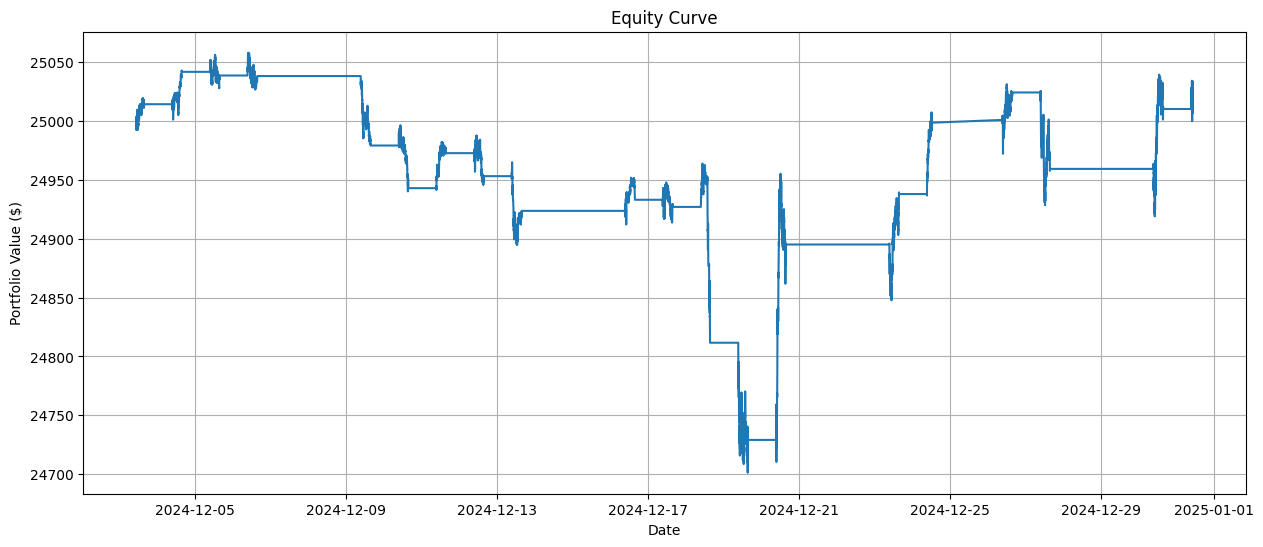


=== Trade Details ===


,entry_time,entry_price,exit_time,exit_price,qty,pnl,duration,return
0,2024-12-03 10:39:00-05:00,602.890015,2024-12-03 15:46:00-05:00,603.789978,16,14.399414,0 days 05:07:00,0.001440
1,2024-12-04 09:36:00-05:00,605.859985,2024-12-04 15:46:00-05:00,607.580017,16,27.520508,0 days 06:10:00,0.002752
2,2024-12-05 09:43:00-05:00,607.544983,2024-12-05 15:46:00-05:00,607.349976,16,-3.120117,0 days 06:03:00,-0.000312
3,2024-12-06 09:31:00-05:00,607.799988,2024-12-06 15:46:00-05:00,607.770020,16,-0.479492,0 days 06:15:00,-0.000048
4,2024-12-09 09:32:00-05:00,607.820007,2024-12-09 10:26:00-05:00,606.530029,16,-20.639648,0 days 00:54:00,-0.002064
5,2024-12-09 10:30:00-05:00,606.580017,2024-12-09 10:48:00-05:00,605.359924,16,-19.521484,0 days 00:18:00,-0.001952
6,2024-12-09 10:54:00-05:00,605.469971,2024-12-09 15:46:00-05:00,604.289978,16,-18.879883,0 days 04:52:00,-0.001888
7,2024-12-10 09:42:00-05:00,604.540100,2024-12-10 15:07:00-05:00,603.304993,16,-19.761719,0 days 05:25:00,-0.001976
8,2024-12-10 15:09:00-05:00,603.419983,2024-12-10 15:46:00-05:00,602.390015,16,-16.479492,0 days 00:37:00,-0.001648
9,2024-12-11 09:32:00-05:00,605.929993,2024-12-11 15:46:00-05:00,607.789978,16,29.759766,0 days 06:14:00,0.002976



=== Additional Statistics ===
Sharpe Ratio (assuming 0% risk-free rate): 0.10
Max Drawdown: $356.98
Average Trade Duration: 0 days 03:36:04.186046511


In [10]:
# Run backtest and analyze results
if data is not None:
    trades_df, equity_df = backtest_strategy(data)
    print("=== Backtest Results ===")
    print(f"Number of trades: {len(trades_df)}")
    
    if not trades_df.empty:
        print(f"Total P&L: ${trades_df['pnl'].sum():.2f}")
        print(f"Average P&L per trade: ${trades_df['pnl'].mean():.2f}")
        print(f"Win rate: {(trades_df['pnl'] > 0).mean():.1%}")
        
        # Plot equity curve
        plt.figure(figsize=(15, 6))
        plt.plot(equity_df.index, equity_df['equity'])
        plt.title('Equity Curve')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.show()
        
        print("\n=== Trade Details ===")
        display(trades_df[['entry_time', 'entry_price', 'exit_time', 'exit_price', 'qty', 'pnl', 'duration', 'return']])
        
        print("\n=== Additional Statistics ===")
        print(f"Sharpe Ratio (assuming 0% risk-free rate): {(trades_df['return'].mean() / trades_df['return'].std() * np.sqrt(252)):.2f}")
        print(f"Max Drawdown: ${(equity_df['equity'].max() - equity_df['equity'].min()):.2f}")
        print(f"Average Trade Duration: {trades_df['duration'].mean()}")
    else:
        print("No trades were executed during the backtest period")
else:
    print("No data available for backtesting")

# Algo 2.1

In [35]:
def backtest_strategy(data):
    """Backtest the specified trading strategy."""
    position_open = False
    entry_price = None
    position_qty = 0
    cash = 25000  # Initial capital
    trades = []
    equity_curve = []
    trailing_stop_percent = 0.002  # 0.2%

    # Create shifted columns for previous bar comparison
    data = data.copy()
    data['prev_open'] = data['Open'].shift(1)
    data['prev_close'] = data['Close'].shift(1)

    for timestamp, row in data.iloc[1:].iterrows():
        current_price = float(row['Close'])

        if in_trading_window(timestamp):
            if not position_open:
                # Entry condition
                prev_close = float(row['prev_close'])
                prev_open = float(row['prev_open'])
                current_open = float(row['Open'])

                if (prev_close > prev_open) and (current_price > current_open):
                    shares = int(10000 / current_price)
                    if shares > 0:
                        position_open = True
                        entry_price = current_price
                        position_qty = shares
                        trades.append({
                            'entry_time': timestamp,
                            'entry_price': entry_price,
                            'qty': position_qty,
                            'direction': 'long'
                        })
            else:
                # Update trailing stop price
                stop_price = entry_price * (1 - trailing_stop_percent)
                if current_price <= stop_price:
                    # Exit condition
                    pnl = (current_price - entry_price) * position_qty
                    cash += pnl
                    trades[-1].update({
                        'exit_time': timestamp,
                        'exit_price': current_price,
                        'pnl': pnl
                    })
                    position_open = False
                    position_qty = 0
                    entry_price = None

        elif position_open:
            # Exit at the end of the trading window
            pnl = (current_price - entry_price) * position_qty
            cash += pnl
            trades[-1].update({
                'exit_time': timestamp,
                'exit_price': current_price,
                'pnl': pnl
            })
            position_open = False
            position_qty = 0
            entry_price = None

        # Track equity
        current_equity = cash
        if position_open:
            current_equity += (current_price - entry_price) * position_qty
        equity_curve.append((timestamp, current_equity))

    trades_df = pd.DataFrame(trades)
    equity_df = pd.DataFrame(equity_curve, columns=['timestamp', 'equity']).set_index('timestamp')

    if not trades_df.empty:
        trades_df['duration'] = trades_df['exit_time'] - trades_df['entry_time']
        trades_df['return'] = trades_df['pnl'] / 10000

    return trades_df, equity_df


C:\Users\clayb\AppData\Local\Temp\ipykernel_28496\3374611899.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(row['Close'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_28496\3374611899.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_close = float(row['prev_close'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_28496\3374611899.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_open = float(row['prev_open'])
C:\Users\clayb\AppData\Local\Temp\ipykernel_28496\3374611899.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_open = float(row['Open'])


=== Backtest Results ===
Number of trades: 40
Total P&L: $-177.08
Average P&L per trade: $-4.43
Win rate: 35.0%


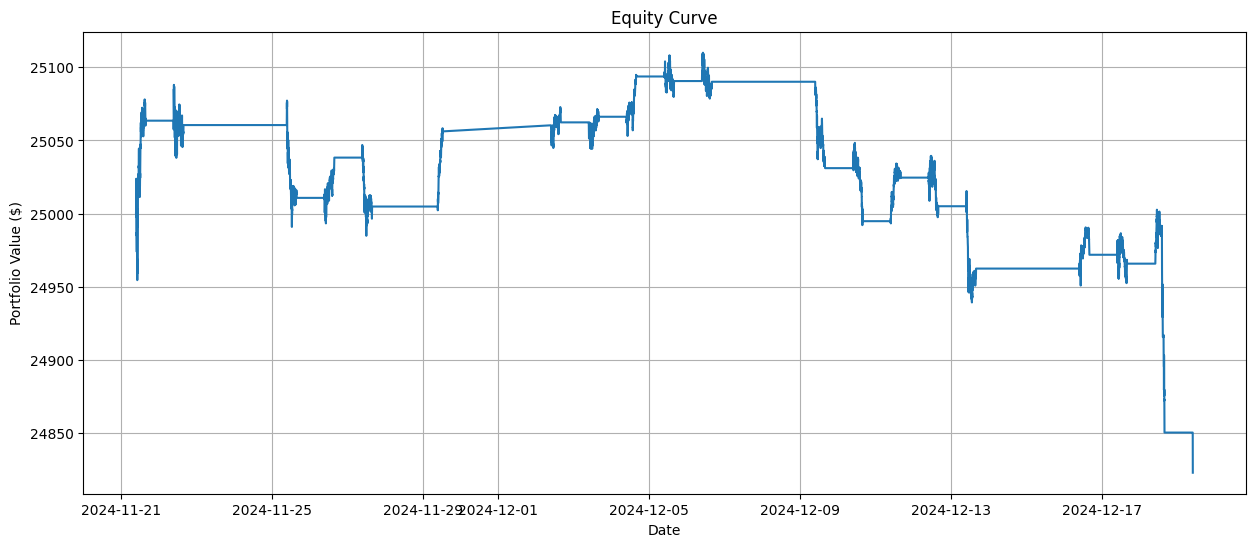


=== Trade Details ===


,entry_time,entry_price,exit_time,exit_price,qty,pnl,duration,return
0,2024-11-21 09:44:00-05:00,589.869995,2024-11-21 10:07:00-05:00,588.450012,16,-22.719727,0 days 00:23:00,-0.002272
1,2024-11-21 10:09:00-05:00,589.159973,2024-11-21 10:29:00-05:00,587.739197,16,-22.732422,0 days 00:20:00,-0.002273
2,2024-11-21 10:32:00-05:00,587.799988,2024-11-21 15:46:00-05:00,594.210022,17,108.970581,0 days 05:14:00,0.010897
3,2024-11-22 09:34:00-05:00,594.510010,2024-11-22 10:28:00-05:00,593.312500,16,-19.160156,0 days 00:54:00,-0.001916
4,2024-11-22 10:30:00-05:00,594.180115,2024-11-22 15:46:00-05:00,595.190002,16,16.158203,0 days 05:16:00,0.001616
5,2024-11-25 09:32:00-05:00,599.690002,2024-11-25 10:11:00-05:00,598.049988,16,-26.240234,0 days 00:39:00,-0.002624
6,2024-11-25 10:15:00-05:00,598.229980,2024-11-25 12:12:00-05:00,596.809998,16,-22.719727,0 days 01:57:00,-0.002272
7,2024-11-25 12:19:00-05:00,596.549988,2024-11-25 12:46:00-05:00,595.260010,16,-20.639648,0 days 00:27:00,-0.002064
8,2024-11-25 12:48:00-05:00,595.770020,2024-11-25 15:46:00-05:00,597.010010,16,19.839844,0 days 02:58:00,0.001984
9,2024-11-26 09:31:00-05:00,599.200012,2024-11-26 15:46:00-05:00,600.919983,16,27.519531,0 days 06:15:00,0.002752



=== Additional Statistics ===
Sharpe Ratio (assuming 0% risk-free rate): -2.56
Max Drawdown: $287.04
Average Trade Duration: 0 days 04:31:00


In [36]:
# Assuming 'data' is your DataFrame with historical minute-level data
if data is not None:
    trades_df, equity_df = backtest_strategy(data)

    print("=== Backtest Results ===")
    print(f"Number of trades: {len(trades_df)}")

    if not trades_df.empty:
        print(f"Total P&L: ${trades_df['pnl'].sum():.2f}")
        print(f"Average P&L per trade: ${trades_df['pnl'].mean():.2f}")
        print(f"Win rate: {(trades_df['pnl'] > 0).mean():.1%}")

        # Plot equity curve
        plt.figure(figsize=(15, 6))
        plt.plot(equity_df.index, equity_df['equity'])
        plt.title('Equity Curve')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.show()

        print("\n=== Trade Details ===")
        display(trades_df[['entry_time', 'entry_price', 'exit_time', 'exit_price', 'qty', 'pnl', 'duration', 'return']])

        print("\n=== Additional Statistics ===")
        print(f"Sharpe Ratio (assuming 0% risk-free rate): {(trades_df['return'].mean() / trades_df['return'].std() * np.sqrt(252)):.2f}")
        max_drawdown = (equity_df['equity'].cummax() - equity_df['equity']).max()
        print(f"Max Drawdown: ${max_drawdown:.2f}")
        print(f"Average Trade Duration: {trades_df['duration'].mean()}")
    else:
        print("No trades were executed during the backtest period")
else:
    print("No data available for backtesting")
